This notebook will train a convolutional network on MNIST
as a starting point for our domain adaptation application.

A model will be stored at the end and will be used
in the follow-up notebook 

    7_domain_adaptation.ipynb
    
The only difference with our typical approach when
applying convolutional nets on MNIST is the transformation
of the grayscale images to RGB images, which is
required for the adaptation to the new dataset,
which is basically a MNIST with coloured and textured
backgrounds.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.MaxPool2d(2),
            nn.Dropout2d(),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        features = features.view(x.shape[0], -1)
        logits = self.classifier(features)
        return logits

In [4]:
class GrayscaleToRgb:
    """Convert a grayscale image to rgb"""
    def __call__(self, image):
        image = np.array(image)
        image = np.dstack([image, image, image])
        return Image.fromarray(image)

In [5]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [6]:
# Training settings
input_size=(3,28,28,)
batch_size=64
test_batch_size=1000
epochs=10
lr=0.01
momentum=0.0   
seed=1
log_interval=100

In [7]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [8]:
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           GrayscaleToRgb(),
                           transforms.ToTensor() 
                       ])),
        batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           GrayscaleToRgb(),
                           transforms.ToTensor()                          
                       ])),
        batch_size=test_batch_size, shuffle=True, **kwargs)

Extracting ../data\MNIST\raw\train-images-idx3-ubyte.gz to ../data\MNIST\raw


Extracting ../data\MNIST\raw\train-labels-idx1-ubyte.gz to ../data\MNIST\raw


Extracting ../data\MNIST\raw\t10k-images-idx3-ubyte.gz to ../data\MNIST\raw


Extracting ../data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\MNIST\raw
Processing...
Done!


..\torch\csrc\utils\tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [9]:
imgs,labels = next(iter(train_loader))
print(imgs.shape)



torch.Size([64, 3, 28, 28])


In [10]:
labels

tensor([9, 3, 0, 1, 2, 4, 6, 8, 1, 1, 2, 3, 0, 7, 0, 0, 1, 3, 9, 4, 1, 1, 2, 9,
        0, 0, 1, 4, 6, 2, 1, 3, 0, 8, 8, 1, 9, 5, 9, 0, 2, 8, 7, 2, 9, 5, 7, 1,
        4, 1, 8, 6, 1, 8, 7, 0, 1, 3, 4, 3, 2, 7, 7, 7])

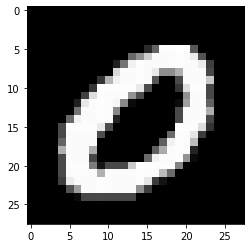

In [11]:
plt.imshow(np.transpose(imgs[2], (1,2,0) ) )

In [12]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
criterion = torch.nn.CrossEntropyLoss()

In [13]:
summary(model,input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             760
         MaxPool2d-2           [-1, 10, 12, 12]               0
              ReLU-3           [-1, 10, 12, 12]               0
            Conv2d-4             [-1, 20, 8, 8]           5,020
         MaxPool2d-5             [-1, 20, 4, 4]               0
         Dropout2d-6             [-1, 20, 4, 4]               0
            Linear-7                   [-1, 50]          16,050
              ReLU-8                   [-1, 50]               0
           Dropout-9                   [-1, 50]               0
           Linear-10                   [-1, 10]             510
Total params: 22,340
Trainable params: 22,340
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.08
Params size (MB): 0.09
Estimated Tot

In [14]:
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.324133
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.299729
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.260267
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.144550
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.698136
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.287620
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.995291
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.193858
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.994035
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.911277

Test set: Average loss: 0.0004, Accuracy: 8845/10000 (88%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.580243
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.676999
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.456933
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.567806
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.654306
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.443857
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.930586
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.546676
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.559433
T

In [15]:
torch.save(model.state_dict(),"conv_for_domain_adaptation.pt")